In [1]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [28]:
## We will make the circuits for U_kineff and U_keff first

y = np.sqrt(2) - 1  #Fixed constant for toulouse point

#In these calculations, the hopping term is directly proportional to v_f = sin(theta)

def Ul(N,v):
    Ul = Operator([[np.exp(-1j*(2*np.pi*y/N)*v), 0], 
                   [0, np.exp(1j*(2*np.pi*y/N)*v)]])
    return Ul

def Uz(v):
    Uz = Operator([[np.exp(-1j*np.pi*v*y), 0,0,0], 
                   [0, np.exp(1j*np.pi*v*y),0,0],
                   [0, 0,np.exp(1j*np.pi*v*y),0],
                   [0,0,0,np.exp(-1j*np.pi*v*y)]])
    return Uz



def U_keff(theta_k,N):
    a = theta_k
    b = (4*np.pi*y**2)/N

    n = (2*a)**2 + b**2
    k = np.sqrt(n)
    U_keff = Operator([[np.exp(-1j*b), 0, 0, 0], 
                       [0, np.cos(k) -(2j*a/k)*np.sin(k), -1j*(b/k)*np.sin(k), 0],
                       [0, 1j*(b/k)*np.sin(k), -np.cos(k) -(2j*a/k)*np.sin(k), 0],
                       [0, 0, 0, np.exp(1j*b)]])
    return U_keff

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,np.cos(theta),1j*np.exp(1j*beta)*np.sin(theta),0],
                   [0,1j*np.exp(-1j*beta)*np.sin(theta),np.cos(theta),0],
                   [0,0,0,np.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angle):


    fsim1 = fsim(angle/2,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(t/2,\phi)$')

        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-2,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(t/2,\phi)$')

    qc.unitary(Uz(-angle),[qc.num_qubits-1,qc.num_qubits-2],label = r'$exp(-i\delta H_L)$')   

#def initial_state_circuit(N):
    ##We will define the initial state here
                          
def non_int_circ(N,theta,theta_k,t,barriers = False):
    v = np.sin(theta)
    angle = 2*v
    

    qc = QuantumCircuit(N+1)
    qc.unitary(Uz(v/2),[N,N-1],label = r'$U_z^{1/2}$')
    qc.unitary(Ul(N,-v/2),[N],label = r'$(U_l^\dag)^{1/2}$')

    if barriers:
        qc.barrier()

    for i in range(t):
        qc.unitary(Ul(N,v/2),[N],label = r'$U_l^{1/2}$')
        qc.unitary(U_keff(theta_k,N),[N,N-1],label = r'$U_{k_{eff}}$')  #U_keff part
        qc.unitary(Ul(N,v/2),[N],label = r'$U_l^{1/2}$')


        qc.unitary(Uz(v/2),[N,N-1],label = r'$U_z^{1/2}$')
        add_fsim_half(qc,angle)
        qc.unitary(Uz(v/2),[N,N-1],label = r'$U_z^{1/2}$')  #U_kineff part

        if barriers:
            qc.barrier()
    
    qc.unitary(Ul(N,v/2),[N],label = r'$(U_l^\dag)^{-1/2}$')
    qc.unitary(Uz(-v/2),[N,N-1],label = r'$U_z^{-1/2}$')

    return qc


In [19]:
u_keff_test = U_keff(np.pi/2,4)
## Check if U_keff is unitary

print(u_keff_test.is_unitary())

#multiply by the adjoint to check if it is identity
print(u_keff_test.adjoint().compose(u_keff_test).data)

True
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


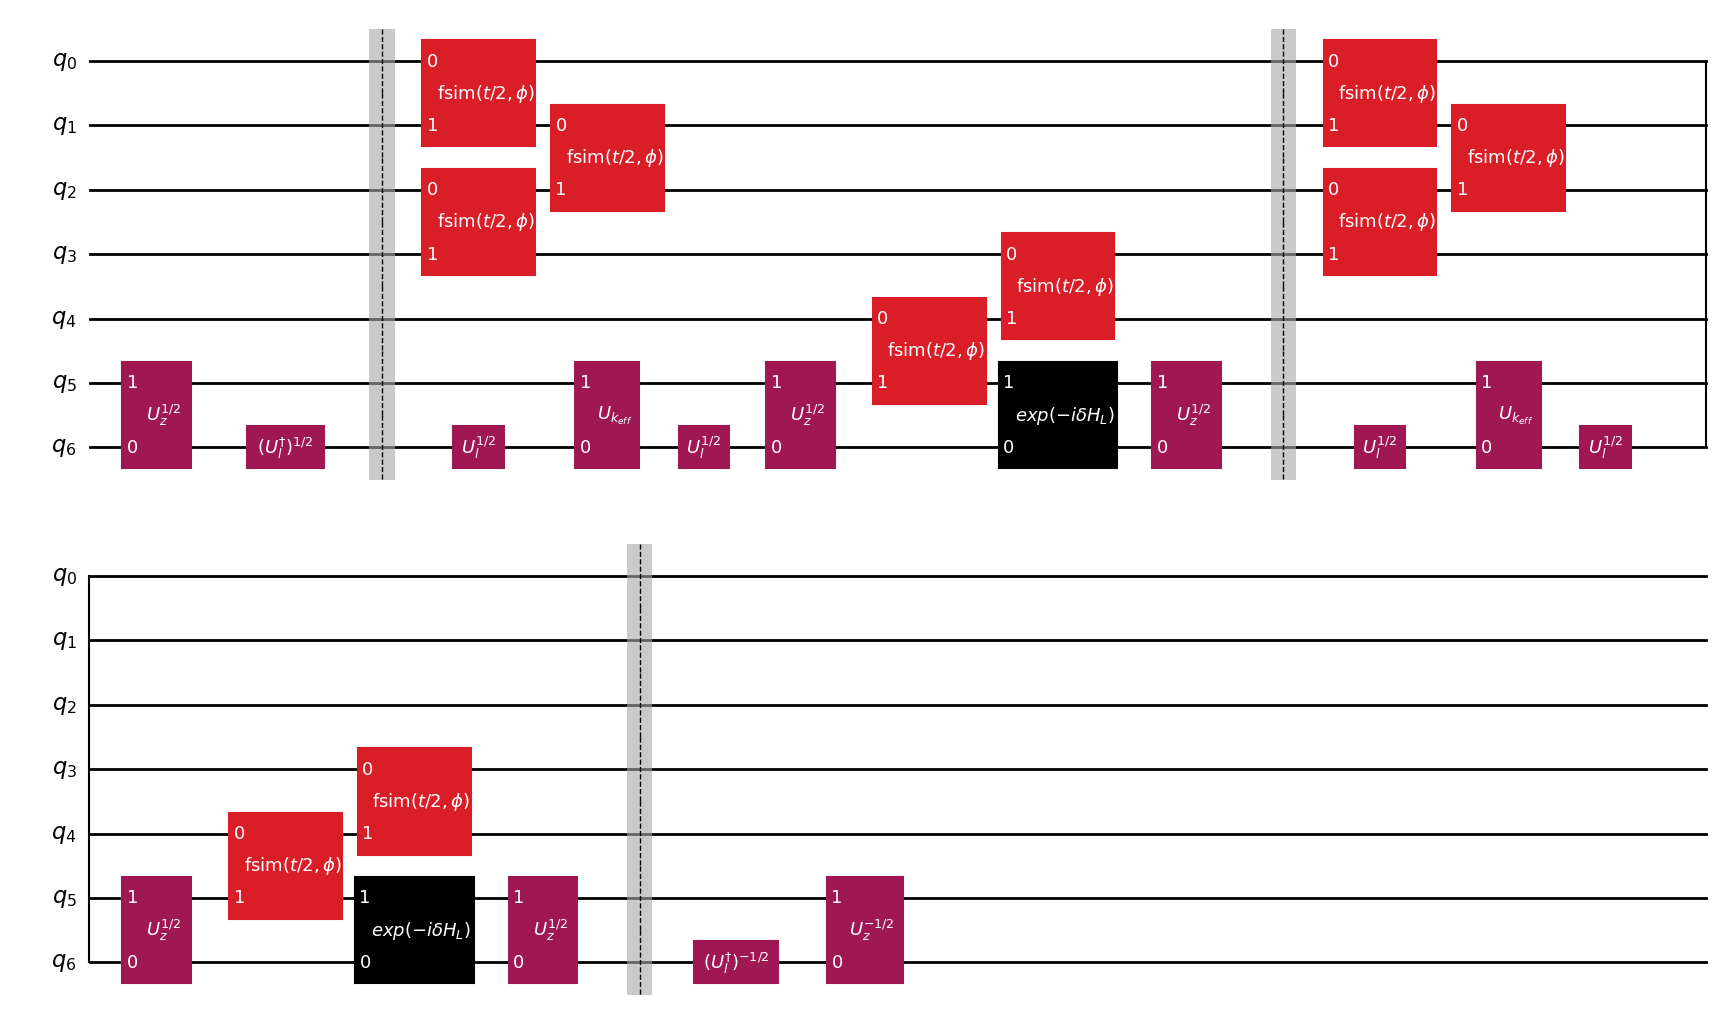

In [31]:
qc = non_int_circ(6,np.pi/4,np.pi/4,2,barriers = True)


gate_colours = {
    "displaycolor": {
        r'U_z^{1/2}$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(t/2,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$exp(-i\delta H_L)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}
qc.draw(output = 'mpl',style = gate_colours, reverse_bits=False)